
# <center>Predicting the returns of orders  for a retail shoe seller</center>




## Introduction
###  Challenge SD210 2018
#### Authors :  Florence D'Alché & Umut Şimşekli & Moussab Djerrab


**Context of the challenge:**

An electronic commerce company sells shoes, and has a high return rate of his products, more than 20%. This large number of returns and exchanges has a negative impact on its margin. To remedy this problem, the company wants to better understand this phenomenon, and have tools to quantify the probability of return for a given product. It makes available its database of orders placed between October 2011 and October 2015, its product feedback data, and its customer and product databases (provide the data dictionary).

**Goal of the challenge:**
<ul>
<li>Identify conditions that favor product return (eg what type of product is usually returned, which customer is more keen on returning a product, what type of order or purchase context most often leads to returns?)</li>
<li>Build a return forecast template for each product from a shopping cart.
</li>
</ul>

To go further: This project aimes at making stand out purchasing behaviors. With this knowledge, the e-merchant wishes to use this data to better plan his activity. In particular, he wants to forecast the turnover generated by his clients.



**Training data:**

There will be $N= 1067290$ lines of orders in the training dataset. For each order  the training dataset reports if the command has been returned (***ReturnQuantityBin***) and the quantity returned (***ReturnQuantity***). The column to target (***ReturnQuantityBin***) which is a binary column ($y = 1$ if returned and $y=0$ otherwise). 

**Test data:**

The test data contain $N_\text{test} = 800468$ lines of orders. Everything else is similar to the training data.


## Additional Data

As part of the challenge, two additional datasets are avalaible namely (**customers.csv**) and (**products.csv**). Those to sets contains informations on custmers and on the products. A good prediction model will necessarily require extraction of information comming from this dataset. Students are free to use these data as they see fit. Please keep in mind that both sets containes also customers and products that are not present in the training or test sets.

A dictionnary of variables (**dictionnary.xlsx**) is avalaible in the folder containing the datasets. Please refer to it so as to have a definition of the variables at hand.


## The goal and the performance criterion

In this challenge, we will use an evaluation metric, which is commonly used in binary prediction, namely the ROC AUC criteria. **The closest to 1 the better (be affarait if its below 0).**
Hence the form of the file to send is of the form :


| <center> probability </center>  |
| ------------- |
| <center> .90  </center>         |
| <center> ...  </center>         |
| <center> .42  </center>         |


The order of the probabilities needs to respect the order in the test set.



# Training Data

https://www.dropbox.com/sh/uo4oudw43j45mp3/AACA0UqkitNKSWdE_7fs2Wbla?dl=0


In [1]:
from __future__ import division
#from importlib import reload
import os
import sys
#reload(sys)
#sys.setdefaultencoding("utf-8") -> PYTHON 2 ONLY


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from datetime import datetime
timeBeginning = datetime.now()

## Loading the data

In [2]:
customers = pd.read_csv("customers.csv")
products = pd.read_csv("products.csv")
X_train = pd.read_csv("X_train.csv")
X_test   = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")


## Understanding the data

In [3]:
customers.head()

,CustomerId,CountryISOCode,BirthDate,Gender,FirstOrderDate
0,14089083.0,SE,1979-02-05 00:00:00,Femme,2013-03-16 23:00:05
1,12862066.0,FR,1982-08-04 00:00:00,Femme,2012-02-14 17:47:33
2,14791699.0,FR,1965-04-02 00:00:00,Femme,2013-10-04 23:10:42
3,10794664.0,FR,1966-04-09 00:00:00,Femme,2010-03-25 18:46:59
4,15268576.0,ES,1980-04-22 00:00:00,Femme,2014-03-19 10:48:39


In [4]:
X_train.head()

,OrderNumber,VariantId,LineItem,CustomerId,OrderStatusLabel,OrderTypelabel,SeasonLabel,PayementModeLabel,CustomerTypeLabel,IsoCode,DeviceTypeLabel,PricingTypeLabel,TotalLineItems,Quantity,UnitPMPEUR,OrderCreationDate,OrderShipDate,OrderNumCustomer,IsOnSale,BillingPostalCode
0,73521754,439729,1,12443972,Expédié,DIRECT,Automne/Hiver,Carte bancaire,Nouveau,FR,ND,Plein Tarif,2,1,"52,64",2011-10-26 12:10:48,2011-10-26 18:27:00,1,0.0,87000
1,73521754,440174,2,12443972,Expédié,DIRECT,Automne/Hiver,Carte bancaire,Nouveau,FR,ND,Plein Tarif,2,1,"52,64",2011-10-26 12:10:48,2011-10-26 18:27:00,1,0.0,87000
2,73525226,494501,1,12443958,Expédié,DIRECT,Automne/Hiver,Carte bancaire,Nouveau,FR,ND,Plein Tarif,1,1,"13,17",2011-10-26 12:11:38,2011-10-26 17:48:00,1,0.0,77700
3,73529009,439590,1,12443946,Expédié,DIRECT,Automne/Hiver,Carte bancaire,Nouveau,FR,ND,Plein Tarif,2,1,"56,4",2011-10-26 12:13:09,2011-10-26 17:59:00,1,0.0,44600
4,73529009,559476,2,12443946,Expédié,DIRECT,Automne/Hiver,Carte bancaire,Nouveau,FR,ND,Plein Tarif,2,1,37,2011-10-26 12:13:09,2011-10-26 17:59:00,1,0.0,44600


In [5]:
products.head()

,VariantId,GenderLabel,MarketTargetLabel,SeasonLabel,SeasonalityLabel,BrandId,UniverseLabel,TypeBrand,ProductId,ProductType,...,UpperHeight,HeelHeight,PurchasePriceHT,IsNewCollection,SubtypeLabel,UpperMaterialLabel,LiningMaterialLabel,OutSoleMaterialLabel,RemovableSole,SizeAdviceDescription
0,728257.0,Homme,Classique,Automne/Hiver,Saisonnier,66.0,DÃ©tente,Standard,17267.0,Baskets,...,NaN,0.0,30.50,0.0,Montantes,NaN,NaN,NaN,False,Prenez une taille en dessous de votre pointure...
1,806356.0,Femme,ND,Automne/Hiver,Saisonnier,842.0,ND,Standard,30824.0,Baskets,...,0.0,0.0,43.00,0.0,Montantes,NaN,NaN,NaN,True,Prenez votre pointure habituelle
2,768790.0,Femme,ND,Automne/Hiver,Reconduit,988.0,Ville,Standard,62475.0,Bottines et boots,...,6.0,3.0,54.90,0.0,Bout pointu,NaN,NaN,NaN,False,Prenez votre pointure habituelle
3,515679.0,Femme,ND,Automne/Hiver,Saisonnier,769.0,Ville,Standard,43983.0,Escarpins,...,0.0,13.0,34.50,0.0,Bout rond,NaN,NaN,NaN,False,Prenez votre pointure habituelle
4,1025246.0,Femme,ND,Automne/Hiver,Saisonnier,1244.0,ND,Standard,81493.0,Bottines et boots,...,8.0,4.0,43.76,0.0,Bout rond,NaN,NaN,NaN,False,Prenez votre pointure habituelle


In [6]:
y_train.head()

,OrderNumber,LineItem,ReturnQuantity,ReturnQuantityBin
0,73521754,1,0.0,0.0
1,73521754,2,0.0,0.0
2,73525226,1,1.0,1.0
3,73529009,1,1.0,1.0
4,73529009,2,1.0,1.0


## Defining a feature transformation

In [7]:
def funk_mask(d):
    " Defining a simple mask over the input data "
    columns_ext = ["OrderNumber","VariantId", "CustomerId","OrderCreationDate","OrderShipDate","BillingPostalCode"]
    X1 = d.loc[:,[xx for xx in d.columns if xx not in columns_ext]]
    
    g = lambda x: x.replace(",",".")
    
    # enabling string to float conversion
    X1.UnitPMPEUR=(X1.UnitPMPEUR).replace(',', '.',regex=True)
    X1.UnitPMPEUR = pd.to_numeric(X1.UnitPMPEUR)
    
    columns2bin = [x for x in X1.columns if X1[x].dtype == np.dtype('O')] # find out which columns are type objects
    X2 = pd.get_dummies(X1.loc[:,columns2bin])
    X1 = X1.loc[:,[xx for xx in X1.columns if xx not in columns2bin]]
    res = pd.concat([X1,X2],axis=1)
    res = res.fillna(0)
    return(res)

## Applying the mask

In [8]:
x1 = funk_mask(X_train)
x2 = funk_mask(X_test)
seleckt_columns = np.intersect1d(x1.columns,x2.columns)
x1 = x1.loc[:,seleckt_columns]
x2 = x2.loc[:,seleckt_columns]
seleckt_columns.shape


(56,)

# Matrix correlation : preprocessing : 

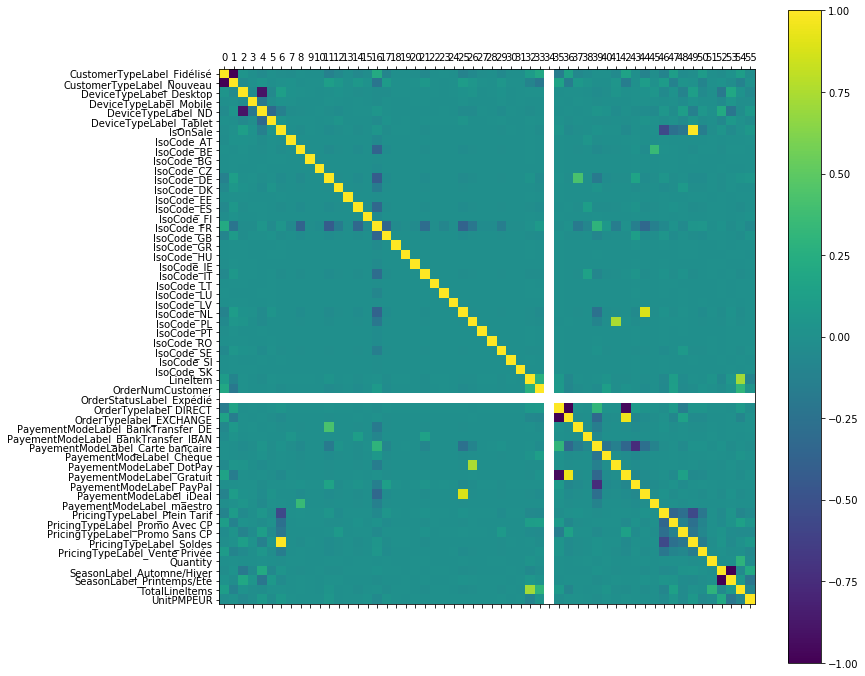

In [9]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr = x1.corr()

# plot correlation matrix


# - Table - #
cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())
# - End Table - #

# HeatMap
fig, ax = plt.subplots(figsize=(12,12))
cax=ax.matshow(corr,vmin=-1, vmax=1)
fig.colorbar(cax)
plt.xticks(range(len(corr.columns)), [i for i in range(len(corr.columns))]);
plt.yticks(range(len(corr.columns)), corr.columns);
plt.show()

# End HeatMap

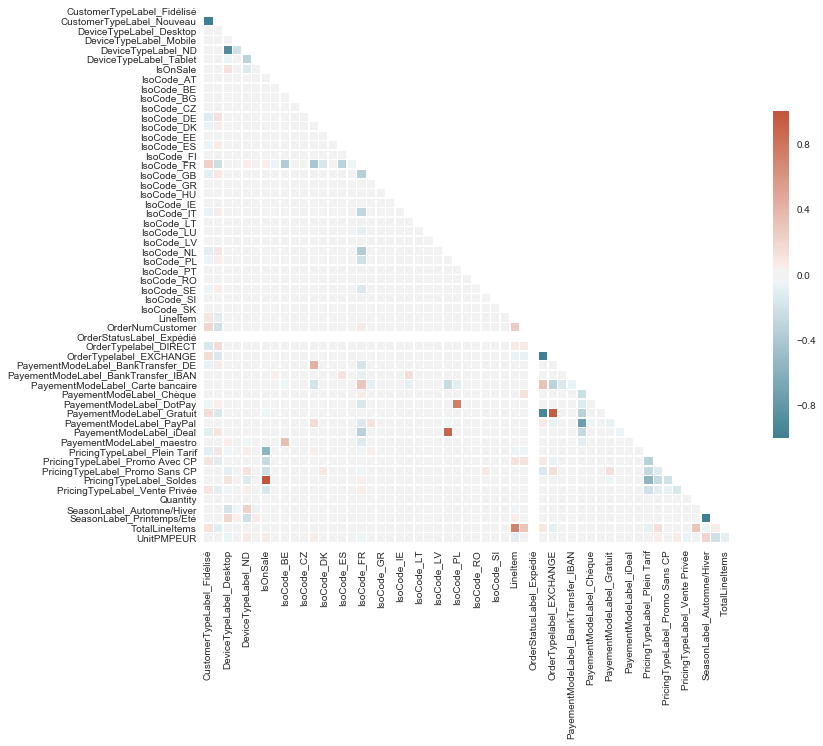

In [10]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")


# Compute the correlation matrix
corr3 = x1.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr3, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr3, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

## Supervised learning : Logistic regression model

In [11]:
from sklearn.cross_validation import cross_val_score, ShuffleSplit
scores = []
clf = LogisticRegression()
X=x1.iloc[:50000]
Y=y_train.ReturnQuantityBin[:50000]
for i in range(X.shape[1]):
     score = cross_val_score(clf, X.iloc[:, i:i+1], Y, scoring="roc_auc",
                              cv=ShuffleSplit(len(X), 3, .3))
     scores.append((round(np.mean(score), 3), seleckt_columns[i]))
scores=np.sort(scores)
print(scores)



c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[['0.527' 'CustomerTypeLabel_Fidélisé']
 ['0.524' 'CustomerTypeLabel_Nouveau']
 ['0.5' 'DeviceTypeLabel_Desktop']
 ['0.5' 'DeviceTypeLabel_Mobile']
 ['0.5' 'DeviceTypeLabel_ND']
 ['0.5' 'DeviceTypeLabel_Tablet']
 ['0.5' 'IsOnSale']
 ['0.5' 'IsoCode_AT']
 ['0.5' 'IsoCode_BE']
 ['0.5' 'IsoCode_BG']
 ['0.5' 'IsoCode_CZ']
 ['0.518' 'IsoCode_DE']
 ['0.5' 'IsoCode_DK']
 ['0.5' 'IsoCode_EE']
 ['0.502' 'IsoCode_ES']
 ['0.5' 'IsoCode_FI']
 ['0.521' 'IsoCode_FR']
 ['0.504' 'IsoCode_GB']
 ['0.5' 'IsoCode_GR']
 ['0.5' 'IsoCode_HU']
 ['0.5' 'IsoCode_IE']
 ['0.505' 'IsoCode_IT']
 ['0.5' 'IsoCode_LT']
 ['0.5' 'IsoCode_LU']
 ['0.5' 'IsoCode_LV']
 ['0.506' 'IsoCode_NL']
 ['0.5' 'IsoCode_PL']
 ['0.5' 'IsoCode_PT']
 ['0.5' 'IsoCode_RO']
 ['0.5' 'IsoCode_SE']
 ['0.5' 'IsoCode_SI']
 ['0.5' 'IsoCode_SK']
 ['0.531' 'LineItem']
 ['0.538' 'OrderNumCustomer']
 ['0.5' 'OrderStatusLabel_Expédié']
 ['0.503' 'OrderTypelabel_DIRECT']
 ['0.503' 'OrderTypelabel_EXCHANGE']
 ['0.5' 'PayementModeLabel_BankTransfer_DE']
 

In [12]:
clf = LogisticRegression()
clf.fit(x1.iloc[:50000], y_train.ReturnQuantityBin[:50000])
y_tosubmit = clf.predict_proba(x2.loc[:,x1.columns])

## Analysing the result

In [13]:
index = np.argsort(-abs(clf.coef_)) # the minus is to order in desceding order, clf.coef contains the weight of each features in the regressor

# Showing the most importants features until now (in the regressor logistic). 
names_columns = (list(x1))

j = 1
for i in (index[0]):
    print('#',j,"-",names_columns[i], "\t\tCoef:", clf.coef_[0,i])
    j = j +1


# 1 - IsoCode_IT 		Coef: -1.055374874032344
# 2 - IsoCode_DE 		Coef: 0.7618258346073896
# 3 - IsoCode_NL 		Coef: 0.7603888915491361
# 4 - PayementModeLabel_Gratuit 		Coef: -0.5199054385424675
# 5 - Quantity 		Coef: -0.5058599857812403
# 6 - IsoCode_ES 		Coef: -0.36476384425352154
# 7 - OrderTypelabel_DIRECT 		Coef: -0.3350133553621479
# 8 - PayementModeLabel_PayPal 		Coef: 0.3088659139941773
# 9 - IsoCode_FR 		Coef: -0.27149899948518036
# 10 - CustomerTypeLabel_Nouveau 		Coef: -0.25609445487275695
# 11 - PayementModeLabel_iDeal 		Coef: -0.25544849142600823
# 12 - DeviceTypeLabel_ND 		Coef: -0.24267799624542175
# 13 - OrderStatusLabel_Expédié 		Coef: -0.24267799624542175
# 14 - IsoCode_BE 		Coef: -0.21655041430692795
# 15 - SeasonLabel_Printemps/Eté 		Coef: -0.21621748499225504
# 16 - PayementModeLabel_Carte bancaire 		Coef: 0.20230589131027857
# 17 - IsoCode_GB 		Coef: 0.17380855343292473
# 18 - PricingTypeLabel_Vente Privée 		Coef: -0.11339655996949656
# 19 - OrderTypelabel_EXCHANGE 	

## Score of our prediction : on the train

In [14]:
yres = clf.predict_proba(x1.loc[:100000,x1.columns])
roc_auc_score(y_train.ReturnQuantityBin.iloc[:100001],yres[:,1])

# Submission to the system
# COMMENTED np.savetxt('y_pred.txt', y_tosubmit[:,1], fmt='%f')

0.6192956974520804


# <center> That's all folks; Good Luck! </center>

## TRYING NEW THINGS:

In [15]:
print("running time until here : %f secondes" % (datetime.now()-timeBeginning).total_seconds())

running time until here : 42.429522 secondes


## Getting to know better some features:

In [16]:
print("All possible values:", products['SizeAdviceDescription'].unique())

# choosing the ones that are differents
differentSizes = [ 'ModÃ¨le Ã©troit, convient aux pieds fins',
       'Prenez une taille au-dessus de votre pointure habituelle',
       'Prenez une taille en dessous de votre pointure habituelle',
                        'ModÃ¨le confortable, convient aux pieds larges',
                         'Prenez une taille au-dessus de sa pointure !',
                  'Chaussant petit. Si vous Ãªtes habituellement entre deux pointures, nous vous conseillons de choisir une demi taille au-dessus de votre pointure habituelle.',
       'Chaussant particuliÃ¨rement gÃ©nÃ©reux. Nous vous conseillons de choisir deux tailles en dessous de votre pointure habituelle.']
print("All possible values:", customers['Gender'].unique())
print("All possible values:", products['GenderLabel'].unique())

All possible values: ['Prenez une taille en dessous de votre pointure habituelle'
 'Prenez votre pointure habituelle'
 'Prenez une taille en dessous de sa pointure !'
 'Ce modÃ¨le chausse normalement'
 'Prenez une taille au-dessus de votre pointure habituelle'
 'ModÃ¨le confortable, convient aux pieds larges' nan
 'ModÃ¨le Ã©troit, convient aux pieds fins'
 'Prenez une taille au-dessus de sa pointure !'
 "Chaussant gÃ©nÃ©reux. Nous vous conseillons de commander votre pointure habituelle et d'ajouter Ã©ventuellement une demi-semelle."
 'Chaussant particuliÃ¨rement petit. Nous vous conseillons de choisir deux pointures au-dessus de votre pointure habituelle.'
 'Chaussant trÃ¨s confortable, convient aux pieds trÃ¨s larges et/ou trÃ¨s sensibles.'
 'Chaussant particuliÃ¨rement gÃ©nÃ©reux. Nous vous conseillons de choisir deux tailles en dessous de votre pointure habituelle.'
 'Chaussant gÃ©nÃ©reux. Si vous Ãªtes habituellement entre deux pointures, nous vous conseillons de choisir une demi 

## Choose features 

In [17]:
## Interesting features for linear regression ; they all have a score > 0.52 
interesting_scores=['CustomerTypeLabel_Fidélisé','CustomerTypeLabel_Nouveau','IsoCode_FR','LineItem','OrderNumCustomer', 
                    'TotalLineItems', 'UnitPMPEUR']

# Manage the columns to keep and to drop
all_columns = ['OrderNumber', 'VariantId', 'LineItem', 'CustomerId',
       'OrderStatusLabel', 'OrderTypelabel', 'SeasonLabel_x',
       'PayementModeLabel', 'CustomerTypeLabel', 'IsoCode', 'DeviceTypeLabel',
       'PricingTypeLabel', 'TotalLineItems', 'Quantity', 'UnitPMPEUR',
       'OrderCreationDate', 'OrderShipDate', 'OrderNumCustomer', 'IsOnSale',
       'BillingPostalCode', 'CountryISOCode', 'BirthDate', 'Gender',
       'FirstOrderDate', 'GenderLabel', 'MarketTargetLabel', 'SeasonLabel_y',
       'SeasonalityLabel', 'BrandId', 'UniverseLabel', 'TypeBrand',
       'ProductId', 'ProductType', 'SupplierColor', 'ProductColorId',
       'MinSize', 'MaxSize', 'CalfTurn', 'UpperHeight', 'HeelHeight',
       'PurchasePriceHT', 'IsNewCollection', 'SubtypeLabel',
       'UpperMaterialLabel', 'LiningMaterialLabel', 'OutSoleMaterialLabel',
       'RemovableSole', 'SizeAdviceDescription']

# ONLY VARIABLE TO CHANGE :
picked_columns =['LineItem', 'OrderTypelabel', 'SeasonLabel_x', 'PayementModeLabel',
       'CustomerTypeLabel', 'IsoCode', 'DeviceTypeLabel', 'TotalLineItems',
       'Quantity', 'UnitPMPEUR', 'OrderCreationDate', 'OrderNumCustomer','ProductType',
       'IsOnSale', 'CountryISOCode', 'BirthDate', 'Gender', 'GenderLabel',
       'SeasonLabel_y', 'TypeBrand', 'ProductType', 'HeelHeight',
       'IsNewCollection','SizeAdviceDescription','ProductColorId']

dropped_columns = list(set(all_columns)^set(picked_columns))

print(dropped_columns)

['CustomerId', 'BrandId', 'PricingTypeLabel', 'MarketTargetLabel', 'SeasonalityLabel', 'VariantId', 'OutSoleMaterialLabel', 'PurchasePriceHT', 'ProductId', 'OrderShipDate', 'SupplierColor', 'UpperMaterialLabel', 'FirstOrderDate', 'RemovableSole', 'CalfTurn', 'MaxSize', 'SubtypeLabel', 'LiningMaterialLabel', 'BillingPostalCode', 'UniverseLabel', 'UpperHeight', 'OrderStatusLabel', 'OrderNumber', 'MinSize']


## Obtain suitable database

In [18]:
def funk_mask_2(d):
    " Defining a simple mask over the input data "    
    X1 = d
    
    # conversion string to float
    X1.UnitPMPEUR=(X1.UnitPMPEUR).replace(',', '.',regex=True)
    X1.UnitPMPEUR = pd.to_numeric(X1.UnitPMPEUR)
    
    # new feature
    XDifSize = 1*X1['SizeAdviceDescription'].isin(differentSizes)
    
    # Buying different sex
    hommeBuyer =X1['Gender'].isin(['Homme'])
    femmeBuyer = X1['Gender'].isin(['Femme'])
    hommeProduct = X1['GenderLabel'].isin(['Homme'])
    femmeProduct = X1['GenderLabel'].isin(['Femme'])
    
    XDifGender = 1*np.logical_or(np.logical_xor(hommeBuyer,femmeProduct),
                              np.logical_xor(femmeBuyer,hommeProduct))
    # rewrite dates
    X1.OrderCreationDate = pd.to_datetime(X1.OrderCreationDate)
    X1.BirthDate =  X1.BirthDate.replace('4958','1958',regex=True) #index 90051 line 578918 of csv BAD TIME
    X1.BirthDate = pd.to_datetime(X1.BirthDate)
    
    # get infos on days, months, years, then drop now unused columns
    XMonth = pd.get_dummies(X1.OrderCreationDate.dt.month,'OrderCreationMonth_')
    XDay = pd.get_dummies(X1.OrderCreationDate.dt.day,'OrderCreationDay_')
    XDayOfWeek = pd.get_dummies(X1.OrderCreationDate.dt.dayofweek,'OrderCreationDayOfWeek_')
    XBirthYear = X1.OrderCreationDate.dt.year
    XHour = pd.get_dummies(X1.OrderCreationDate.dt.hour,'OrderCreationHour_')
    XDifSize = pd.get_dummies(XDifSize, 'DifferentSize')
    XDifGender = pd.get_dummies(XDifGender, 'DifferentGender')
    
    print(XDifGender.columns,XDifSize.columns)
    # eliminer features completement dependants
    XDifGender = XDifGender.loc[:,'DifferentGender_1']
    XDifSize = XDifSize.loc[:,'DifferentSize_1']
   
    X1 = X1.drop(['OrderCreationDate'],axis=1)
    X1 = X1.drop(['BirthDate'],axis=1)
    
    
    # arrange to find correct result at the end
    columns2bin = [x for x in X1.columns if (X1[x].dtype == np.dtype('O'))] # find out which columns are type objects
    print(columns2bin)
    X2 = pd.get_dummies(X1.loc[:,columns2bin])
    X1 = X1.loc[:,[xx for xx in X1.columns if xx not in columns2bin]]
    res = pd.concat([X1,X2,XMonth,XDay,XDayOfWeek,XBirthYear, XHour,XDifSize, XDifGender],axis=1)
    res = res.fillna(0)
    return(res)

In [19]:
# Merge datasets with customers & products tables
aux_train = X_train.merge(customers, on="CustomerId",how='left')
aux_test = X_test.merge(customers, on="CustomerId",how='left')
xMerged_train = aux_train.merge(products, on="VariantId",how='left')
xMerged_test = aux_test.merge(products, on="VariantId",how='left')

# Removed unused columns (note : really unused ?) USED!!!
xMerged_train=xMerged_train.drop(dropped_columns,axis=1)
xMerged_test=xMerged_test.drop(dropped_columns,axis=1)

# apply function to arrange the dataset
x1 = funk_mask_2(xMerged_train)
x2 = funk_mask_2(xMerged_test)
select_columns = np.intersect1d(x1.columns,x2.columns)

# apply loc function -> only thing I don't understand well, I think it provides better indexing
x1 = x1.loc[:,select_columns]
x2 = x2.loc[:,select_columns]

select_columns.shape

Index(['DifferentGender_0', 'DifferentGender_1'], dtype='object') Index(['DifferentSize_0', 'DifferentSize_1'], dtype='object')
['OrderTypelabel', 'SeasonLabel_x', 'PayementModeLabel', 'CustomerTypeLabel', 'IsoCode', 'DeviceTypeLabel', 'CountryISOCode', 'Gender', 'GenderLabel', 'SeasonLabel_y', 'TypeBrand', 'ProductType', 'SizeAdviceDescription']
Index(['DifferentGender_0', 'DifferentGender_1'], dtype='object') Index(['DifferentSize_0', 'DifferentSize_1'], dtype='object')
['OrderTypelabel', 'SeasonLabel_x', 'PayementModeLabel', 'CustomerTypeLabel', 'IsoCode', 'DeviceTypeLabel', 'CountryISOCode', 'Gender', 'GenderLabel', 'SeasonLabel_y', 'TypeBrand', 'ProductType', 'SizeAdviceDescription']


(208,)

## Spliting the data in dataset and validation set.

In [20]:
 X1_train, X1_test, y1_train, y1_test = train_test_split(x1, y_train.ReturnQuantityBin[:],
                                                         test_size=0.3, random_state=42)
#x1.loc[:100000,x1.columns]
#y_train.ReturnQuantityBin.iloc[:100001],yres_bagg[:,1]

In [21]:
# Logistic Regression
clf = LogisticRegression()
clf.fit(X1_train, y1_train)
y_tosubmit = clf.predict_proba(x2.loc[:,x1.columns])

In [22]:
index = np.argsort(-abs(clf.coef_)) # the minus is to order in desceding order, clf.coef contains the weight of each features in the regressor

# Showing the most importants features until now (in the regressor logistic). 
names_columns = (list(x1))
names_col_rej = []
j = 1
for i in (index[0]):
    print('#',j,"-",names_columns[i], "\t\tCoef:", clf.coef_[0,i])
    if (abs(clf.coef_[0,i])<0.00001):
        names_col_rej.append(names_columns[i])
    j = j +1


# 1 - UnitPMPEUR 		Coef: 0.010939850720190814
# 2 - OrderNumCustomer 		Coef: 0.010162810056962884
# 3 - HeelHeight 		Coef: 0.005156372924403149
# 4 - TotalLineItems 		Coef: 0.005038074356364916
# 5 - LineItem 		Coef: 0.0024765545197413187
# 6 - OrderCreationDate 		Coef: -0.0008967120489588519
# 7 - GenderLabel_Femme 		Coef: 0.0007582360590075402
# 8 - ProductType_Baskets 		Coef: -0.0005200480331429993
# 9 - IsoCode_FR 		Coef: -0.0005089366096199916
# 10 - GenderLabel_Homme 		Coef: -0.0004582934259054388
# 11 - IsoCode_DE 		Coef: 0.0004482438301894388
# 12 - CustomerTypeLabel_Nouveau 		Coef: -0.0004207050948895085
# 13 - CustomerTypeLabel_Fidélisé 		Coef: 0.0004201856188564768
# 14 - Gender_Homme 		Coef: -0.0003976852069334205
# 15 - Gender_Femme 		Coef: 0.00038742566278314824
# 16 - DifferentSize_1 		Coef: 0.00036146535114816236
# 17 - ProductType_Escarpins 		Coef: 0.0003369699784455988
# 18 - CountryISOCode_FR 		Coef: -0.00032032814392176577
# 19 - PayementModeLabel_Carte bancaire 		C

In [23]:
yres = clf.predict_proba(X1_test)
print(roc_auc_score(y1_test,yres[:,1]))

# Submission to the system
np.savetxt('y_pred2.txt', y_tosubmit[:,1], fmt='%f')

0.5859425611869116


# Trying new regrssors methods

In [24]:
print("running time until here : %f secondes" % (datetime.now()-timeBeginning).total_seconds())

running time until here : 90.175137 secondes


In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import matplotlib as mpl
from sklearn.metrics import r2_score as r2
from matplotlib.pyplot import cm 
from sklearn import datasets, svm, preprocessing
from sklearn.model_selection import cross_val_score

In [26]:
rf = RandomForestClassifier()
scores = []
X=x1.iloc[:50000]
Y=y_train.ReturnQuantityBin[:50000]
for i in range(X.shape[1]):
     score = cross_val_score(rf, X.iloc[:, i:i+1], Y, scoring="roc_auc",
                              cv=ShuffleSplit(len(X), 3, .3))
     scores.append((round(np.mean(score), 3), select_columns[i]))
scores=np.sort(scores)
print(scores)

[['0.5' 'CountryISOCode_AT']
 ['0.499' 'CountryISOCode_BE']
 ['0.5' 'CountryISOCode_BG']
 ['0.5' 'CountryISOCode_CZ']
 ['0.511' 'CountryISOCode_DE']
 ['0.5' 'CountryISOCode_DK']
 ['0.5' 'CountryISOCode_EE']
 ['0.502' 'CountryISOCode_ES']
 ['0.5' 'CountryISOCode_FI']
 ['0.518' 'CountryISOCode_FR']
 ['0.503' 'CountryISOCode_GB']
 ['0.5' 'CountryISOCode_GR']
 ['0.5' 'CountryISOCode_HU']
 ['0.5' 'CountryISOCode_IE']
 ['0.503' 'CountryISOCode_IT']
 ['0.5' 'CountryISOCode_LT']
 ['0.5' 'CountryISOCode_LU']
 ['0.5' 'CountryISOCode_LV']
 ['0.502' 'CountryISOCode_NL']
 ['0.5' 'CountryISOCode_PL']
 ['0.5' 'CountryISOCode_PT']
 ['0.5' 'CountryISOCode_RO']
 ['0.5' 'CountryISOCode_SE']
 ['0.5' 'CountryISOCode_SI']
 ['0.5' 'CountryISOCode_SK']
 ['0.524' 'CustomerTypeLabel_Fidélisé']
 ['0.525' 'CustomerTypeLabel_Nouveau']
 ['0.5' 'DeviceTypeLabel_Desktop']
 ['0.5' 'DeviceTypeLabel_Mobile']
 ['0.5' 'DeviceTypeLabel_ND']
 ['0.5' 'DeviceTypeLabel_Tablet']
 ['0.504' 'DifferentGender_1']
 ['0.521' 'Differe

In [27]:
float(scores[1][0])

0.499

In [28]:
ab = AdaBoostClassifier()
scoresab = []
X=x1.iloc[:50000]
Y=y_train.ReturnQuantityBin[:50000]
for i in range(X.shape[1]):
     score = cross_val_score(ab, X.iloc[:, i:i+1], Y, scoring="roc_auc",
                              cv=ShuffleSplit(len(X), 3, .3))
     scoresab.append((round(np.mean(score), 3), select_columns[i]))
scoresab=np.sort(scoresab)
print(scoresab)

[['0.5' 'CountryISOCode_AT']
 ['0.499' 'CountryISOCode_BE']
 ['0.5' 'CountryISOCode_BG']
 ['0.5' 'CountryISOCode_CZ']
 ['0.511' 'CountryISOCode_DE']
 ['0.5' 'CountryISOCode_DK']
 ['0.5' 'CountryISOCode_EE']
 ['0.5' 'CountryISOCode_ES']
 ['0.5' 'CountryISOCode_FI']
 ['0.515' 'CountryISOCode_FR']
 ['0.502' 'CountryISOCode_GB']
 ['0.5' 'CountryISOCode_GR']
 ['0.5' 'CountryISOCode_HU']
 ['0.5' 'CountryISOCode_IE']
 ['0.503' 'CountryISOCode_IT']
 ['0.5' 'CountryISOCode_LT']
 ['0.5' 'CountryISOCode_LU']
 ['0.5' 'CountryISOCode_LV']
 ['0.504' 'CountryISOCode_NL']
 ['0.5' 'CountryISOCode_PL']
 ['0.5' 'CountryISOCode_PT']
 ['0.5' 'CountryISOCode_RO']
 ['0.5' 'CountryISOCode_SE']
 ['0.5' 'CountryISOCode_SI']
 ['0.5' 'CountryISOCode_SK']
 ['0.525' 'CustomerTypeLabel_Fidélisé']
 ['0.525' 'CustomerTypeLabel_Nouveau']
 ['0.5' 'DeviceTypeLabel_Desktop']
 ['0.5' 'DeviceTypeLabel_Mobile']
 ['0.5' 'DeviceTypeLabel_ND']
 ['0.5' 'DeviceTypeLabel_Tablet']
 ['0.504' 'DifferentGender_1']
 ['0.519' 'Different

## Optimizing to adaboost/RL


In [29]:
golden_features = []
score_wanted = scoresab
for i in range (score_wanted.shape[0]):
    if float(score_wanted[i][0]) > 0.5:
         golden_features.append(score_wanted[i][1])
            

In [31]:
# Decision tree removed (not efficient)

# # Bagging
#bagging = BaggingClassifier(base_estimator=tree)
#bagging.fit(X1_train, y1_train)
#yres_bagg = bagging.predict_proba(X1_test)
#roc_auc_score(y1_train,yres_bagg[:,1])
#y_tosubmit_bagg = bagging.predict_proba(x2.loc[:,x1.columns])

# ONLY TRAINING WITH THE BEST FEATURES

#X1_train_golden =  X1_train.loc[:,[xx for xx in X1_train.columns if xx in golden_features]]
#X1_test_golden = X1_test.loc[:,[xx for xx in X1_train.columns if xx in golden_features]]
#X1_train_golden =  X1_train.loc[:,[xx for xx in X1_train.columns if not xx in names_col_rej]]
#X1_test_golden = X1_test.loc[:,[xx for xx in X1_train.columns if not xx in names_col_rej]]
X1_train_golden = X1_train
X1_test_golden = X1_test

# RandomForest
rf = RandomForestClassifier()
rf.fit(X1_train_golden, y1_train)
yres_rf = rf.predict_proba(X1_test_golden)
print(roc_auc_score(y1_test,yres_rf[:,1]))
y_tosubmit_rf = rf.predict_proba(x2.loc[:,X1_train_golden.columns])


# AdaBoost -> SEEMS TO BE THE BEST, DO NOT REMOVE RANDOMFOREST THOUGH
ab = AdaBoostClassifier()
ab.fit(X1_train_golden, y1_train)
yres_ab = ab.predict_proba(X1_test_golden)
print(roc_auc_score(y1_test,yres_ab[:,1]))
y_tosubmit_ab = ab.predict_proba(x2.loc[:,X1_train_golden.columns])

#gb = GradientBoostingClassifier()
#gb.fit(X1_train_golden, y1_train)
#yres_gb = gb.predict_proba(X1_test_golden)
#print(roc_auc_score(y1_test,yres_gb[:,1]))
#y_tosubmit_gb = gb.predict_proba(x2.loc[:,X1_train_golden.columns])

# Submission to the system
#np.savetxt('y_pred_bagg.txt', y_tosubmit_bagg[:,1], fmt='%f')
np.savetxt('y_pred_rf.txt', y_tosubmit_rf[:,1], fmt='%f')
np.savetxt('y_pred_ab.txt', y_tosubmit_ab[:,1], fmt='%f')
#np.savetxt('y_pred_gb.txt', y_tosubmit_gb[:,1], fmt='%f')

0.621491002910205
0.6621252777169842


In [ ]:
nzidx = np.where(gb.feature_importances_)
ranking = np.argsort(gb.feature_importances_[nzidx])
best_features = tuple(np.array(nzidx)[:, ranking])
best_features[0].shape
golden_features = []
for i in range((best_features[0]).shape[0]):
    golden_features.append(X1_train.columns[best_features[0][i]])
#golden_features

## Cross validation only with the best feat:


In [ ]:
if  __name__ == "__main__":
    X1_train_golden =  X1_train.loc[:,[xx for xx in X1_train.columns if xx in golden_features]]
    X1_test_golden = X1_test.loc[:,[xx for xx in X1_train.columns if xx in golden_features]]
    from sklearn.grid_search import GridSearchCV   #Perforing grid search
    param_test1 = {'n_estimators':np.arange(20,41,10)}
    gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
    param_grid = param_test1, scoring='roc_auc',n_jobs=1,iid=False, cv=5)
    gsearch1.fit(X1_train_golden,y1_train)
    gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

# reference
#https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [ ]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
sns.set(style="white")


# Compute the correlation matrix
corr2 = X1_train_golden.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [ ]:
print("running time until here : %f secondes" % (datetime.now()-timeBeginning).total_seconds())